In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.optimize import fsolve
pyplot.style.use('ggplot')

In [2]:
%run fem_tools.py # I put a lot of code in a seperate file to make this document a little shorter

In [3]:
class laplacian2:
    def __init__(self, k=1, exact='1'):
        self.k = k
    def form(self, x, u, Du, Df):
        return (0, self.k*Du), ((0, 0), (0, self.k*numpy.eye(2)[None,:,:]))
    
class laplacian2temp:
    def __init__(self, porosity, k=1, exact='1'):
        self.k = k
        self.porosity = porosity
    def form(self, x, u, Du, Df):
        # Derivative appears to be wrong
        return (0, Du + self.k*Df/self.porosity * u.reshape(-1, 1)), ((0, 0), (self.k*Df/self.porosity, numpy.eye(2)[None,:,:]))

In [4]:
def solve_pressure_temp(fe, mesh, porosity, permeability):
    prob = laplacian2(k=permeability)
    prob2 = laplacian2temp(porosity, k=permeability)
    x, pressure = fe2_solve(fe, mesh, prob.form, dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    _, temp = fe2_solve(fe, mesh, prob2.form, field=pressure, dirichlet=dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
    return x, pressure, temp

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.29e-14 rnorm 1.16e-15
Newton 1 anorm 4.28e-14 rnorm 3.29e-15


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'triangles'
  s)


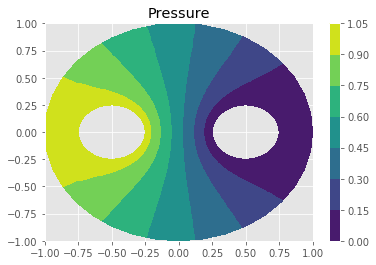

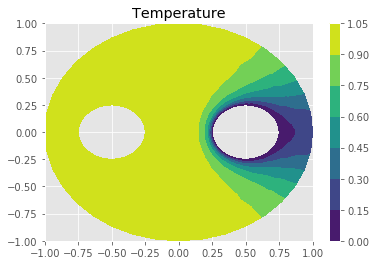

In [5]:
mesh = Mesh(shape='eyes', lcar=0.4, reshape_boundary=True)
porosity = 0.1
permeability = 1
fe = fe2tri(2)

x,pressure,temp = solve_pressure_temp(fe, mesh, porosity, permeability)

pyplot.tricontourf(x[:,0], x[:,1], pressure, triangles=mesh.tri2())
pyplot.title('Pressure')
pyplot.colorbar()

pyplot.figure()
pyplot.tricontourf(x[:,0], x[:,1], temp, triangles=mesh.tri2())
pyplot.title('Temperature')
pyplot.colorbar();

The temperature is solved in one iteration. This implies that I got the Jacobian correct.

In [6]:
def fe2_moment(fe, mesh, u):
    x, Erestrict = mesh.Erestrict(fe.p)
    B = fe.B
    xq, W, dXdx = fe2_geom(fe, mesh)
    isum = 0
    for e,E in enumerate(Erestrict):
        uq = B @ u[E]
        isum += numpy.sum(W[e] * uq * (xq[e][:,1]+1)) # shit so we don't get negative values
    return isum

p1s = []
p2s = []
t1s = []
t2s = []
x1s = []
x2s = []
porosity = 0.3
permeability = 1
sizes = [1,0.5,0.25,0.125,0.0625,.03125]
for s in sizes:
    mesh = Mesh(shape='eyes', lcar=s, reshape_boundary=True)
    fe2 = fe2tri(2)
    fe1 = fe2tri(1)

    x1,pressure1,temp1 = solve_pressure_temp(fe1, mesh, porosity, permeability)
    x2,pressure2,temp2 = solve_pressure_temp(fe2, mesh, porosity, permeability)

    p1 = fe2_moment(fe1, mesh, pressure1)
    p2 = fe2_moment(fe2, mesh, pressure2)
    t1 = fe2_moment(fe1, mesh, temp1)
    t2 = fe2_moment(fe2, mesh, temp2)
    
    p1s.append(p1)
    p2s.append(p2)
    t1s.append(t1)
    t2s.append(t2)
    x1s.append(x1)
    x2s.append(x2)


    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.70e-15 rnorm 3.22e-16
Newton 1 anorm 2.27e-15 rnorm 3.76e-16
Newton 1 anorm 6.69e-15 rnorm 7.17e-16
Newton 1 anorm 9.18e-15 rnorm 8.97e-16
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 3.61e-15 rnorm 5.46e-16
Newton 1 anorm 5.46e-15 rnorm 7.61e-16
Newton 1 anorm 1.12e-14 rnorm 9.87e-16
Newton 1 anorm 1.77e-14 rnorm 1.48e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 6.83e-15 rnorm 8.71e-16
Newton 1 anorm 8.14e-15 rnorm 9.84e-16
Newton 1 anorm 2.05e-14 rnorm 1.54e-15
Newton 1 anorm 2.96e-14 rnorm 2.14e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton 1 anorm 1.26e-14 rnorm 1.17e-15
Newton 1 anorm 1.83e-14 rnorm 1.65e-15
Newton 1 anorm 4.12e-14 rnorm 2.25e-15
Newton 1 anorm 6.22e-14 rnorm 3.32e-15
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
Newton

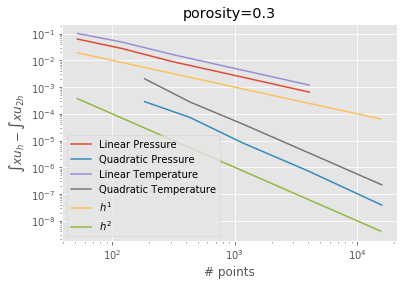

In [7]:
def diffsum(x):
    return [y-x for (x,y) in zip(x[:-1], x[1:])]

s1 = [len(x) for x in x1s]
s2 = [len(x) for x in x2s]

pyplot.loglog(s1[:-1], diffsum(p1s), label="Linear Pressure")
pyplot.loglog(s2[:-1], diffsum(p2s), label="Quadratic Pressure")
pyplot.loglog(s1[:-1], diffsum(t1s), label="Linear Temperature")
pyplot.loglog(s2[:-1], diffsum(t2s), label="Quadratic Temperature")
pyplot.loglog(s1,numpy.power(s1,-1.0), label="$h^{1}$")
pyplot.loglog(s1,numpy.power(s1,-2.0), label="$h^{2}$")
pyplot.ylabel("$\int xu_h - \int x u_{2h}$")
pyplot.xlabel("# points")
pyplot.title("porosity="+str(porosity))
pyplot.legend();

Linear elements are scaling linearly in both temperature and pressure. Quadratic elements are scaling quadratically in temperature and pressure.

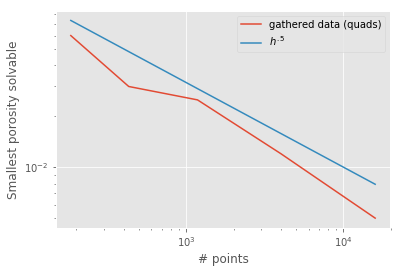

In [8]:
# .0625 .005 15909
# .125 .012 4006
# .25 .025 1178
# .5 .03 430
# 1 .06 184

grid_sizes = [184, 430, 1178, 4006, 15909]
smallest_porosity = [.06, .03, .025, .012, .005]

pyplot.loglog(grid_sizes, smallest_porosity, label="gathered data (quads)")
pyplot.loglog(grid_sizes, numpy.power(grid_sizes, -.5), label="$h^{.5}$")
pyplot.legend()
pyplot.ylabel("Smallest porosity solvable")
pyplot.xlabel("# points");

There appears to be a relationship between grid size and the smallest porosity that creates a correct solution. It appears to scale as $h^{0.5}$.